# Time Series Prediction

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', 100)

from matplotlib import pyplot as plt
%matplotlib inline 

import seaborn as sns

# Scikit-Learn for Modeling
import sklearn

# this is Facebook's new time series library
from fbprophet import Prophet

# Function for splitting training and test set
from sklearn.model_selection import train_test_split 

# Function for creating model pipelines
from sklearn.pipeline import make_pipeline

# For standardization
from sklearn.preprocessing import StandardScaler

# Helper for cross-validation
from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.ar_model import AR
from random import random

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import statsmodels.api as sm

import itertools, calendar

#Augmented Dickey-Fuller test for stationarity
from statsmodels.tsa.stattools import adfuller

** Part 2 of a 2 part series. Part 1 showcased how to visualize and decomose time series data. Using a real-world anonymised dataset from e-commerce retailers, this notebook provides a comparison of time-series sales forecasting methods. 
I have cleaned this data and sorted in in chronolgical decreasing order in offline steps.
The general approach will be to train the modesl on a subset of the sales data history and have them predict 6 months of the future time steps - sales in this case. The predicted data will then be graphed against the real data to show accuracy.**

Throughout this notebook I also use a dummy dataset to illustrate some concepts.
The first notebok in this series should be reviewed prior to this notebook.

** Reload data and run transforms to make the data stationary - as per the first notebook. **

In [2]:
df = pd.read_csv("sorted_txs.csv", usecols=[0,1,2], parse_dates=["report_date"], low_memory=False)
df1 = df[df["supplier_key"]==1]
#this method removes leading and trailing zeros from the sales figures.
df1 = df1[(df1["ordered_product_sales"].eq(0).cumprod().eq(0))&(df1["ordered_product_sales"][::-1].eq(0).cumprod().eq(0))]  

In [3]:
#index the data by report date. This makes it easier to resample. Also drop the supplier_key.
df1.set_index("report_date", inplace=True)
df1_daily = df1.drop(["supplier_key"], axis=1)

In [4]:
#roll-up the daily sales data into weekly sales values
df1_weekly = df1_daily.resample('W').sum()
#roll-up the daily sales data into monthly sales values
df1_monthly = df1_daily.resample('M').sum()

In [5]:
dummy_data = {
'ds':['2016-01-31','2016-02-29', '2016-03-31', '2016-04-30', '2016-05-31', '2016-06-30',\
     '2016-07-31', '2016-08-31', '2016-09-30','2016-10-31','2016-11-30','2016-12-31','2017-01-31',\
    '2017-02-28','2017-03-31','2017-04-30', '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31', \
      '2017-09-30','2017-10-31','2017-11-30','2017-12-31'],
'y': [4,5,4, 8,9,10, 5,4,5, 7,8,7,  5,5,6, 9,10,11, 5,6,6, 8,9,9]
}

In [6]:
dummy_df = pd.DataFrame(dummy_data) 
dummy_df.ds = pd.to_datetime(dummy_df.ds)
dummy_df.set_index("ds", drop=True, inplace=True)

## Training and test data sets
We will use a series of models to predict 6 month sales data. Accordingly we split out monthly sales data into a test date of the most recent 6 months data and a training set of the earlier history.  This is a hard problem given the small dataset that we have and the non-stationarity of our data. Most often rolling 1 month forecasts are generated using all available historical data.

In [7]:
#data is in reverse chronological order
test_data = df1_monthly.tail(6)
train_data = df1_monthly.head(len(df1_monthly)-6)

In [8]:
dummy_test_data = dummy_df.tail(6)
dummy_train_data = dummy_df.head(len(dummy_df)-6)

In [9]:
#test data is last 6 months of sales data
train_data.tail(3), test_data

(             ordered_product_sales
 report_date                       
 2018-03-31                52323.83
 2018-04-30                32255.19
 2018-05-31                46507.34,              ordered_product_sales
 report_date                       
 2018-06-30                45636.61
 2018-07-31                54769.03
 2018-08-31                53309.61
 2018-09-30                48460.61
 2018-10-31                30803.33
 2018-11-30                26359.73)

In [10]:
dummy_train_data.tail(3), dummy_test_data

(             y
 ds            
 2017-04-30   9
 2017-05-31  10
 2017-06-30  11,             y
 ds           
 2017-07-31  5
 2017-08-31  6
 2017-09-30  6
 2017-10-31  8
 2017-11-30  9
 2017-12-31  9)

# Time Series Predicition Models

**In this section we compare a number of time series forecasting methods in increasing order of model 
complexity.**

##  1. Moving Average

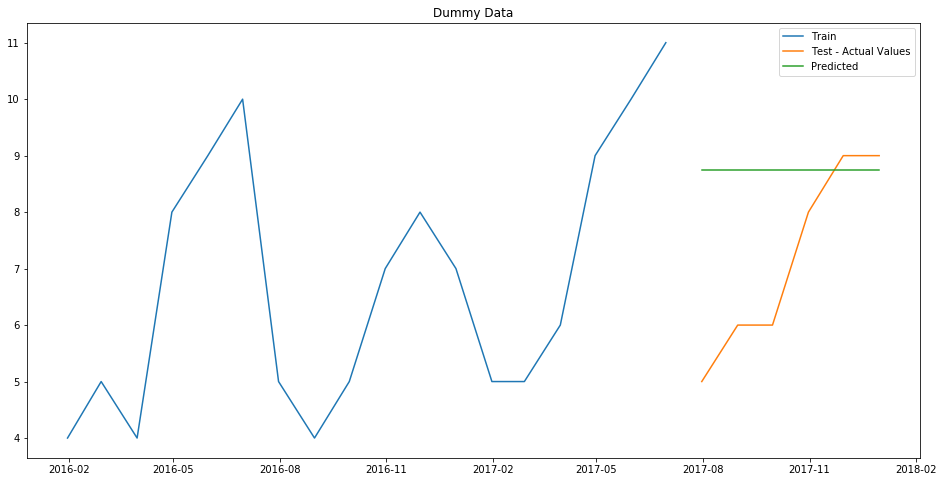

Test MSE: 2.229


In [190]:
model_fit = SimpleExpSmoothing(dummy_train_data).fit(smoothing_level=0.3,optimized=False)
predictions = model_fit.forecast(len(dummy_test_data))
plt.figure(figsize=(16,8))
plt.plot(dummy_train_data, label='Train')
plt.plot(dummy_test_data, label='Test - Actual Values')
plt.plot(predictions, label='Predicted')
plt.legend(loc='best')
plt.title("Dummy Data")
plt.show()
error = np.sqrt(mean_squared_error(dummy_test_data, predictions))
print('Test MSE: %.3f' % error)

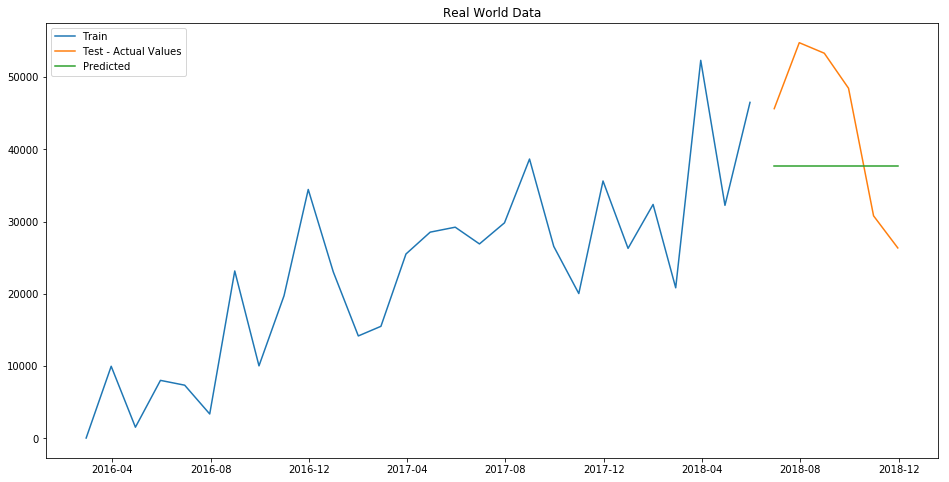

Test MSE: 12200.179


In [240]:
model_fit = SimpleExpSmoothing(train_data).fit(smoothing_level=0.3,optimized=False)
predictions = model_fit.forecast(len(test_data))
plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test - Actual Values')
plt.plot(predictions, label='Predicted')
plt.legend(loc='best')
plt.title("Real World Data")
plt.show()
error = np.sqrt(mean_squared_error(test_data, predictions))
print('Test MSE: %.3f' % error)

This is a simple exponential smoothing average that outputs a single value estimate that is used for all forward forecasts. This is incliuded here a a base case. A smoothng level closer to 1 discounts past values very sharply while a smoothing level closer to 0 places more weight on hitorical transactions
The exponential moving average prediction is a single point value.
There is also a Holt's linear trend algorithm that allows a slope to be asociated to the smoothed exponential average point estimate.

## 2. AutoRegression
The method is suitable for univariate time series without trend and seasonal components. This method would not be expected to perform well on the real-world non-stationary data.
I am using RMSE to judge the quality of the predictions plus I will graph predicted versus actual for a visual comparison. Firs we examine the dummy data and then real sales data. Note that the RMSE values are onl comparable for dummy data to dummy data and real data to real data comparisons.

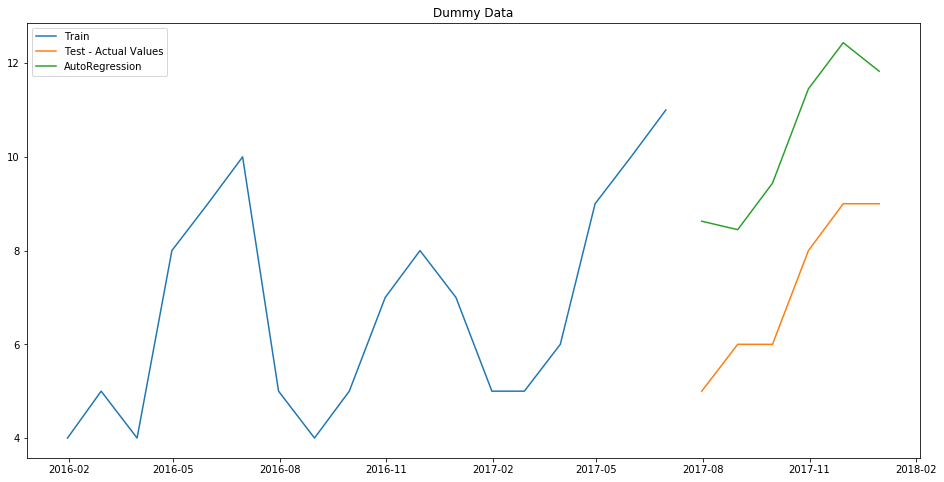

Test RMSE: 3.232


In [192]:
#model_fit = AR(train_data).fit(trend="nc")
#model_fit = AR(dummy_train_data).fit(maxlag=12)
model_fit = AR(dummy_train_data).fit(maxlag=12)
predictions = model_fit.predict(len(dummy_train_data), (len(dummy_train_data) + 5), dynamic=False)
plt.figure(figsize=(16,8))
plt.plot(dummy_train_data, label='Train')
plt.plot(dummy_test_data, label='Test - Actual Values')
plt.plot(predictions, label='AutoRegression')
plt.legend(loc='best')
plt.title("Dummy Data")
plt.show()
error = np.sqrt(mean_squared_error(dummy_test_data, predictions))
print('Test RMSE: %.3f' % error)

** This shows that the AR algorithm can predict the shape/trend of future sales in the stationary dummy data set.**

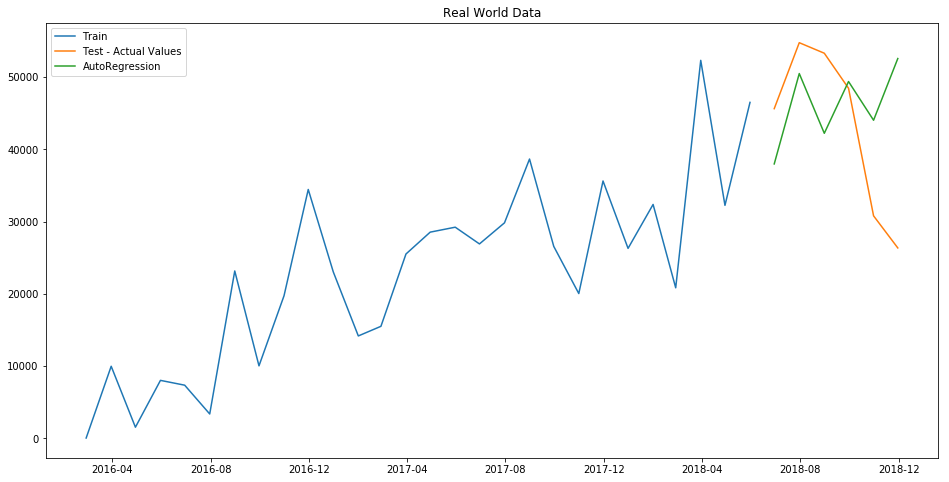

Test RMSE: 13309.253


In [193]:
model_fit = AR(train_data).fit(trend="nc", maxlag=23)
predictions = model_fit.predict(len(train_data), (len(train_data) + 5), dynamic=False)
plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test - Actual Values')
plt.plot(predictions, label='AutoRegression')
plt.legend(loc='best')
plt.title("Real World Data")
plt.show()
error = np.sqrt(mean_squared_error(test_data, predictions))
print('Test RMSE: %.3f' % error)

**The actual values are shown in yellow while the AR values are plotted in green.
Despite manually tunning algorithm parameters the AR algorithm cannot capture the trends in real world sales behaviour in Q3-4 2018.** 

## 3. Holt Winters Forecasting 

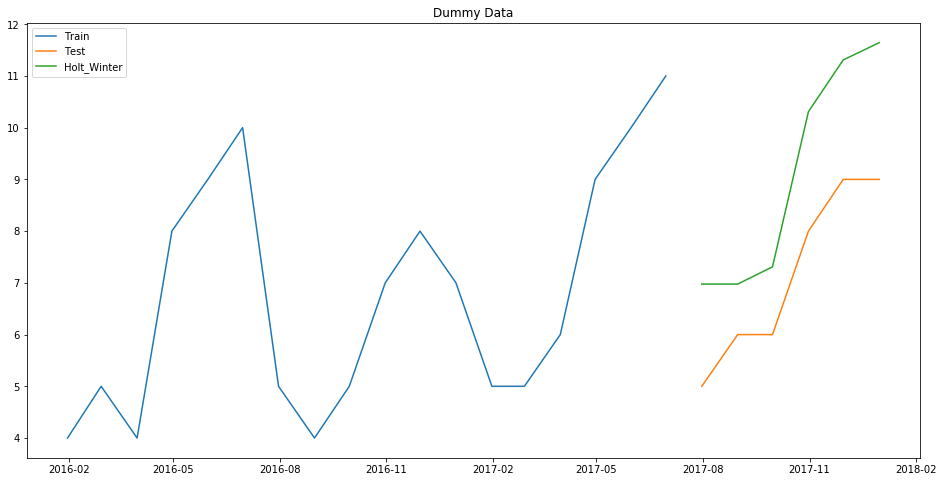

Test MSE: 2.010


In [194]:
fit1 = ExponentialSmoothing(dummy_train_data, seasonal_periods=6,trend='add', seasonal='add',).fit()
predictions = fit1.forecast(len(dummy_test_data))
plt.figure(figsize=(16,8))
plt.plot(dummy_train_data, label='Train')
plt.plot(dummy_test_data, label='Test')
plt.plot(predictions, label='Holt_Winter')
plt.legend(loc='best')
plt.title("Dummy Data")
plt.show()
error = np.sqrt(mean_squared_error(dummy_test_data, predictions))
print('Test MSE: %.3f' % error)

With manual paramter setting, the Holt Winters algorithm models the trend in the dummy data quite nicely.

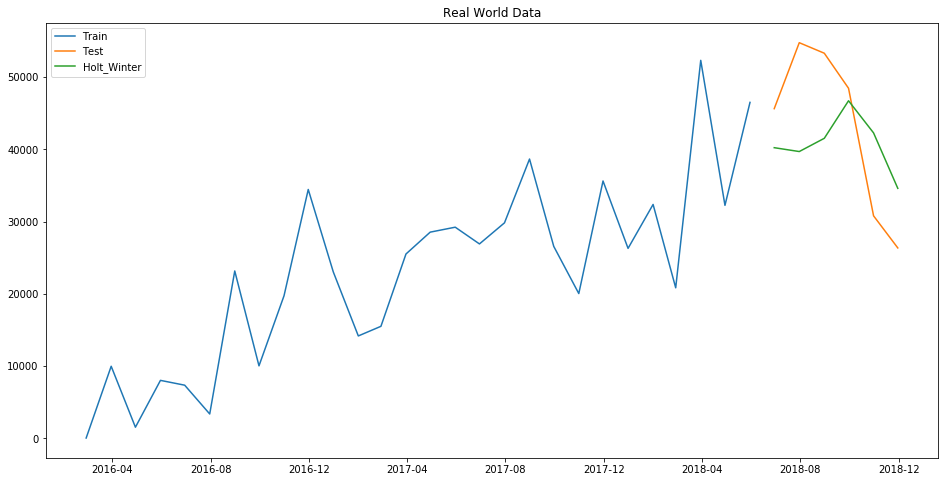

Test MSE: 9980.470


In [195]:
fit1 = ExponentialSmoothing(train_data, seasonal_periods=13,trend='add', seasonal='add',).fit()
predictions = fit1.forecast(len(test_data))
plt.figure(figsize=(16,8))
plt.plot( train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(predictions, label='Holt_Winter')
plt.legend(loc='best')
plt.title("Real World Data")
plt.show()
error = np.sqrt(mean_squared_error(test_data, predictions))
print('Test MSE: %.3f' % error)

The Holt Winters algorithm with manual paramter tuning can capture the downward trend. 
In the previous visualization notebook there is a spike in Partial Auto-Correlation at a lag value of 13.
But this is not a robust method of parametrizing Holt Winters. Other spike values for lag do not perform well.

## 4. Seasonal AutoregRessive Integrated Moving Average - SARIMAX

The previous notebook described the SARIMAX algorithm and how it compensates for non-stationarity in time series data. The previou notebook also showed a method for a grid search to parametrize the algorithm.

In [23]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 4)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [24]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(dummy_train_data,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(3, 0, 1)x(1, 0, 0, 12)12 model - AIC:-48.04109000253153


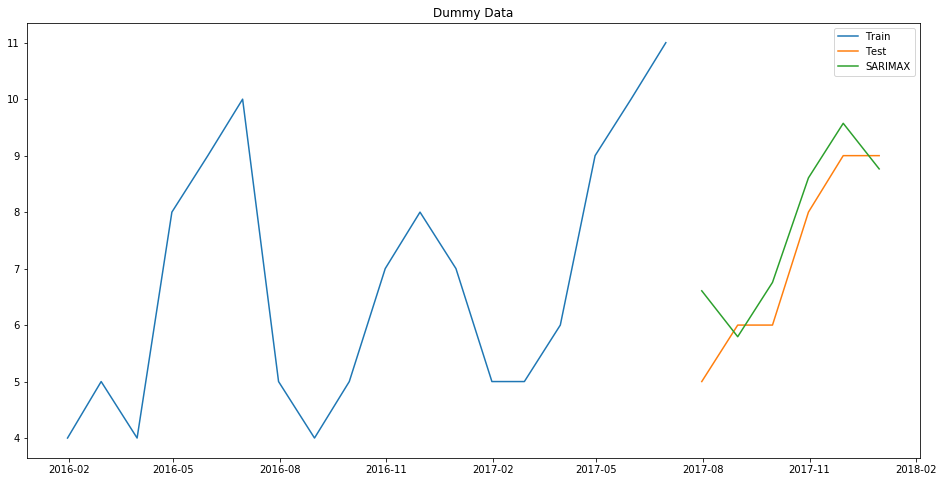

Test MSE: 0.811


In [196]:
fit1 = sm.tsa.statespace.SARIMAX(dummy_train_data, order=(3,0,1),seasonal_order=(1,0,0,12), \
                                 enforce_stationarity=False, enforce_invertibility=False).fit()
predictions = fit1.predict(start="2017-07-31", end="2017-12-31")
plt.figure(figsize=(16,8))
plt.plot( dummy_train_data, label='Train')
plt.plot(dummy_test_data, label='Test')
plt.plot(predictions, label='SARIMAX')
plt.legend(loc='best')
plt.title("Dummy Data")
plt.show()
error = np.sqrt(mean_squared_error(dummy_test_data, predictions))
print('Test MSE: %.3f' % error)

Note how well SARIMX accounts for the trend and seasonality of the dummy data. 
The grid search fpr oder(pdq) values leads to very good performance and shows that stationary data can be very well modelled and forecasted in a reliable and robust way. This is a very good result.

In [27]:
# SARIMAX on Real world Data
sales_txs = df1_monthly["ordered_product_sales"]
sales_txs_log = np.log10(sales_txs)
sales_txs_log.dropna(inplace=True)

In [204]:
sales_txs_log.head(len(sales_txs_log)-5)

report_date
2016-02-29    1.666705
2016-03-31    3.999146
2016-04-30    3.188608
2016-05-31    3.904561
2016-06-30    3.866967
2016-07-31    3.528426
2016-08-31    4.364928
2016-09-30    4.001636
2016-10-31    4.295280
2016-11-30    4.537206
2016-12-31    4.362516
2017-01-31    4.151612
2017-02-28    4.190623
2017-03-31    4.406870
2017-04-30    4.455527
2017-05-31    4.465834
2017-06-30    4.429976
2017-07-31    4.474721
2017-08-31    4.587302
2017-09-30    4.424432
2017-10-31    4.301989
2017-11-30    4.551789
2017-12-31    4.419958
2018-01-31    4.510252
2018-02-28    4.318929
2018-03-31    4.718700
2018-04-30    4.508600
2018-05-31    4.667522
2018-06-30    4.659313
Freq: M, Name: ordered_product_sales, dtype: float64

In [227]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [236]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_txs_log.head(len(sales_txs_log) -5),
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 0)x(1, 0, 0, 12)12 model - AIC:-17.409652147688902


We use 12 for the seasonal parameter. The data is monthly and 12 is a typical choice. 
Nonetheless we did not see a clear 12 month seasonal pattern in the ACF and Partial Correlation Plots shown in the previous notebook.


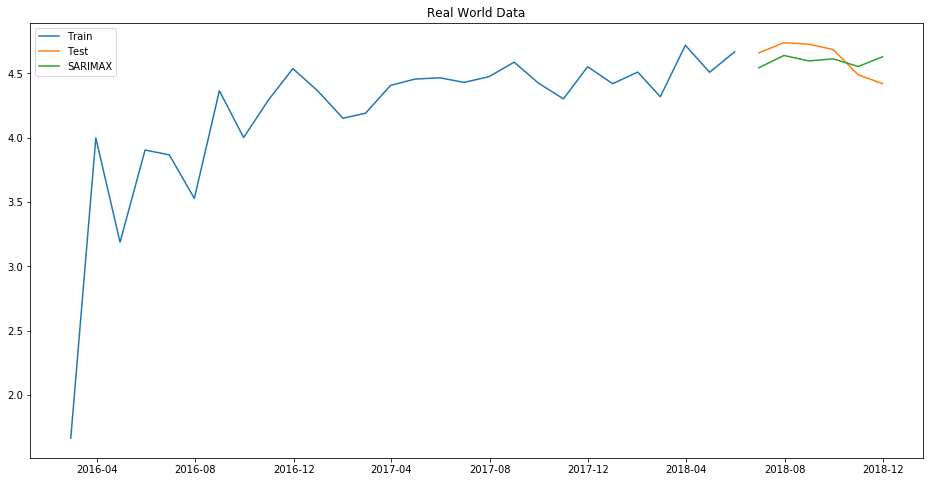

Test MSE: 0.124


In [237]:
fit1 = sm.tsa.statespace.SARIMAX(np.log10(train_data), order=(1,1,0),seasonal_order=(1,0,0,12), \
                                 enforce_stationarity=False, enforce_invertibility=False).fit()

predictions = fit1.predict(start="2018-06-30", end="2018-11-30")
#predictions = fit1.predict(start="2017-08-31", end="2018-10-31")
plt.figure(figsize=(16,8))
plt.plot(np.log10(train_data), label='Train')
plt.plot(np.log10(test_data), label='Test')
plt.plot(predictions, label='SARIMAX')
plt.legend(loc='best')
plt.title("Real World Data")
plt.show()
error = np.sqrt(mean_squared_error(np.log10(test_data), predictions))
print('Test MSE: %.3f' % error)

In [238]:
#reverse log operation for rsme calculation
preds = pd.DataFrame(np.column_stack([np.power(10, predictions)]), columns=["ordered_product_sales"])
preds.set_index(pd.date_range("2018-06-30", freq='M', periods=6), inplace=True)

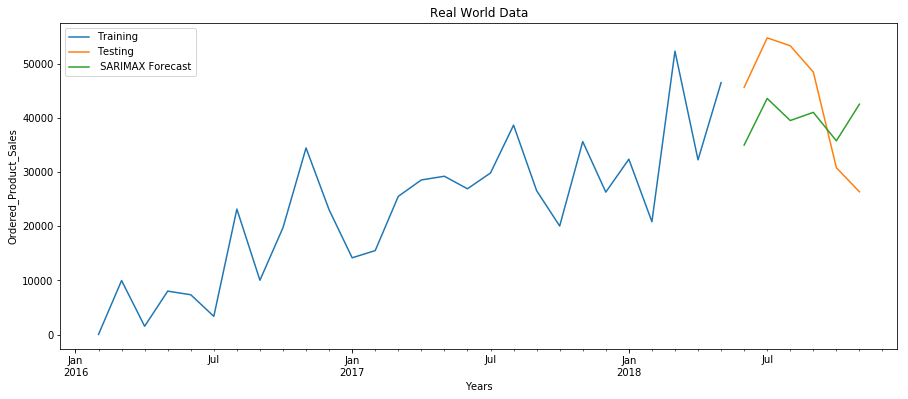

Test MSE: 11330.593


In [239]:
# plot the forecast along with the confidence band
axis = train_data["ordered_product_sales"].plot(label='Training', figsize=(15, 6))
axis = test_data["ordered_product_sales"].plot(label='Testing', figsize=(15, 6))
axis = preds["ordered_product_sales"].plot(label=' SARIMAX Forecast', figsize=(15,6))
axis.set_xlabel('Years')
axis.set_ylabel('Ordered_Product_Sales')
plt.legend(loc='best')
plt.title("Real World Data")
plt.show()
error = np.sqrt(mean_squared_error(test_data, preds))
print('Test MSE: %.3f' % error)

** SARIMAX performance is shown above. It does not capture the downturn in Q4 but as the previous notebook showed there is not sufficient data to predict this. Easier tasks such as predicting rolling 1 month sales with all historical data used are more typical. SARIMAX has the advantage of not requiring manual parameterization. The gridsearch for parameter values allows the fitting of SARIMAX to be automated across a large set of different retailer clients. **

** Time permitting more time series forecasting methods will be tried on this data set including Prophet and LTSM **